In [713]:
import pandas as pd
import numpy as np
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, classification_report, recall_score, make_scorer, precision_recall_fscore_support, roc_auc_score, RocCurveDisplay
from sklearn import metrics
from contextlib import contextmanager
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import loguniform
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, DMatrix
from sklearn.preprocessing import LabelEncoder

import warnings

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## EDA

In [2]:
raw_data = pd.read_csv('datafull.csv', dtype = str)
raw_data.shape

(74576, 71)

In [3]:
#Removing any null products.
df = raw_data.drop_duplicates(subset=['itemid'], keep='first')
df = df.dropna(subset=['itemid'])
df = df.reset_index()
df.shape

(68952, 72)

In [4]:
#Checking any further null values.
df[df.columns[df.isnull().any()]].isnull().sum()

exclusive_price_info    68897
discount                44883
description                59
reference_item_id       68952
brand                   40522
shop_location              14
shop_vouchers           50374
wholesale_tier_list     68345
tier_variations           153
attributes              48792
dtype: int64

In [5]:
#Dropping these as they have excessive null values.
df = df.drop(columns=['exclusive_price_info', 'reference_item_id'])

#Fillnas to allow further manipulations.
df['discount'] = df['discount'].fillna('0') #str to maintain same dtype.
df = df.fillna('None')

In [6]:
#Splitting string into lists, delimiter was set as ';'.
df['categories'] = df['categories'].apply(lambda x : x.split(';'))
df['fe_categories'] = df['fe_categories'].apply(lambda x : x.split(';'))
df['shop_vouchers'] = df['shop_vouchers'].apply(lambda x : x.split(';'))
df['wholesale_tier_list'] = df['wholesale_tier_list'].apply(lambda x : x.split(';'))
df['models'] = df['models'].apply(lambda x : x.split(';'))
df['tier_variations'] = df['tier_variations'].apply(lambda x : x.split(';'))
df['attributes'] = df['attributes'].apply(lambda x : x.split(';'))
df['rating_count'] = df['rating_count'].apply(lambda x : x.split(';'))

#Making separate df for models and attributes to reference later on.
models = pd.DataFrame(df.models.values.tolist()).add_prefix('model')
models.insert(0, 'itemid', df.itemid)

# raw_attributes = pd.DataFrame(df.attributes.values.tolist()).add_prefix('attribute')
# raw_attributes.insert(0, 'itemid', df.itemid)

# attributes = pd.read_csv('tableau_attributes.csv')

#Spltting categories into multiple columns.
df = pd.concat([df, pd.DataFrame(df.categories.values.tolist()).add_prefix('category')], axis=1)
df = pd.concat([df, pd.DataFrame(df.fe_categories.values.tolist()).add_prefix('fe_category')], axis=1)


In [7]:
#categorizing columns
int_cols = ['index', 'itemid', 'shopid', 'userid',
            'price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
            'price_max', 'price', 'price_min',
            'historical_sold', 'sold',
            'ctime',
            'catid',
            'liked_count', 'cmt_count',
            'bundle_deal_id',
            'estimated_days',
            'raw_discount',
            'other_stock', 'discount_stock', 'normal_stock',
            'current_promotion_reserved_stock',
            'brand_id'] #ints
flt_cols = ['rating_star'] #floats
bool_cols = ['has_lowest_price_guarantee', 'show_shopee_verified_label',
             'shopee_verified', 'is_preferred_plus_seller',
             'can_use_bundle_deal', 'can_use_wholesale', 'cb_option',
             'is_pre_order', 'show_free_shipping', 'cod_flag',
             'show_original_guarantee', 'item_has_post',
             'current_promotion_has_reserve_stock',
             'is_cc_installment_payment_eligible'] #bools
objects_cols = ['name', 'description', 'brand', 'categories', 'fe_categories',
                'shop_vouchers', 'wholesale_tier_list', 'models', 'tier_variations',
                'attributes',
                'category0','category1','category2','category3','category4',
                'fe_category0','fe_category1','fe_category2', 'rating_count'] #keep as is
category_cols = ['item_status', 'status', 'condition', 'shop_location']
remove_cols = ['is_mart', 'liked', 'is_adult', 'item_type',
                'is_official_shop', 'is_service_by_shopee',
                'show_recycling_info', 'show_best_price_guarantee',
                'item_has_video', 'item_has_size_recommendation',
                'is_non_cc_installment_payment_eligible',
                'has_low_fulfillment_rate',
                'is_partial_fulfilled',
                'userid', 'discount', 'show_discount', 'stock'] #non_target cols

In [8]:
#Converting cols to appropriate dtypes
df[int_cols] = df[int_cols].astype(int)
df[flt_cols] = df[flt_cols].astype(float)
df[category_cols] = df[category_cols].astype('category')
for col in bool_cols:
    df[col] = df[col].map({'0': False, '1': True, 'False': False, 'True': True})

#Convert ctime to datetime    
df['ctime'] = pd.to_datetime(df['ctime'], unit='s')

#Remove cols
df = df.drop(columns=remove_cols)

df.shape

(68952, 61)

In [9]:
#Set the -1 values to base value for the prices before discount
df['price_max_before_discount'] = df.apply(lambda row : row['price_max'] if (row['raw_discount'] == 0) else row['price_max_before_discount'], axis = 1)
df['price_before_discount'] = df.apply(lambda row : row['price'] if (row['raw_discount'] == 0) else row['price_before_discount'], axis = 1)
df['price_min_before_discount'] = df.apply(lambda row : row['price_min'] if (row['raw_discount'] == 0) else row['price_min_before_discount'], axis = 1)

In [10]:
#Converting price into real life amounts
price_cols = ['price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
              'price_max', 'price', 'price_min']

df[price_cols] = df[price_cols].apply(lambda x : x/100000)

In [11]:
#Merging with shop details
shop_df = pd.read_csv('shops.csv', index_col=0)
shop_df = shop_df.drop_duplicates(subset=['shopid'], keep='first') # Has some duplicates
df = pd.merge(df,shop_df[['shopid','name']], on='shopid', how='inner')
df = df.rename(columns={'name_x': 'product_name', 'name_y': 'shop_name'})

In [12]:
#Taking a subset of columns and rearranging for easier analysis
sub_cols = ['itemid',
            'shopid',
            'product_name',
            'description',
            'brand',
            'price_min',
            'price',
            'price_max',
            'price_min_before_discount',
            'price_before_discount',
            'price_max_before_discount',
            'historical_sold',
            'sold',
            'catid',
            'category0',
            'category1',
            'category2',
            'category3',
            'category4',
            'fe_category0',
            'fe_category1',
            'fe_category2',
            'normal_stock',
            'discount_stock',
            'other_stock',
            'current_promotion_reserved_stock',
            'raw_discount',
            'ctime',
            'liked_count',
            'cmt_count',
            'shop_name',
            'shop_location',
            'rating_star',
            'rating_count',
            'item_status',
            'show_shopee_verified_label',
            'show_original_guarantee',
            'show_free_shipping',
            'cod_flag',
            'item_has_post',
            'shopee_verified',
            'is_preferred_plus_seller',
            'is_cc_installment_payment_eligible',
            'wholesale_tier_list',
            'cb_option',
            'is_pre_order',
            'estimated_days']

df_full = df.copy()
df = df[sub_cols]
df_copy = df.copy()
# df = df.query('sold != 0') #Filter out non sales

#set revenue columns
df['revenue'] = df['price'] * df['sold']
df['historical_revenue'] = df['price'] * df['historical_sold']

#reset index
df = df.reset_index(drop=True)

In [13]:
import re

def get_clean_text(input_text) -> str:
    '''Removes emojis and \n code to reduce noise for modelling. Can be used for name or description. Also reduced model training time by half.'''
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r' ', input_text)
    text = text.replace('\n', ' ')
    text = re.sub(r'(?<=[.,])(?=[^\s])', r' ', text)
    text = re.sub(r' +', ' ', text)
    return text

df.description = df.description.apply(get_clean_text)


In [14]:
df = df[df['catid'] == 100637]

In [15]:
#Will be added later!
others_df = df[df['fe_category1'] == 'Others']

In [16]:
df = df[df['fe_category1'] != 'Others']

In [17]:
df['fe_categories'] = df['fe_category1'] + '/' + df['fe_category2']

In [18]:
pre_df = df.copy()

In [492]:
pre_df.shape

(54258, 50)

### Considerations:

- IDEALLY not to filter test data, keep it as is
- Can only use product name, not description
- Can filter the first level to sports and outdoors as this is doable.
- Consider f1-score
- Note that there will be alot of noise and theres nothing I can do about it.
- 80% is fine, 85% would be amazing!
- AUC

In [326]:
drop_classes = df['fe_categories'].value_counts()[df['fe_categories'].value_counts() <= 20].index.to_list()

df = df[df['fe_categories'].isin(drop_classes) == False]

<Axes: >

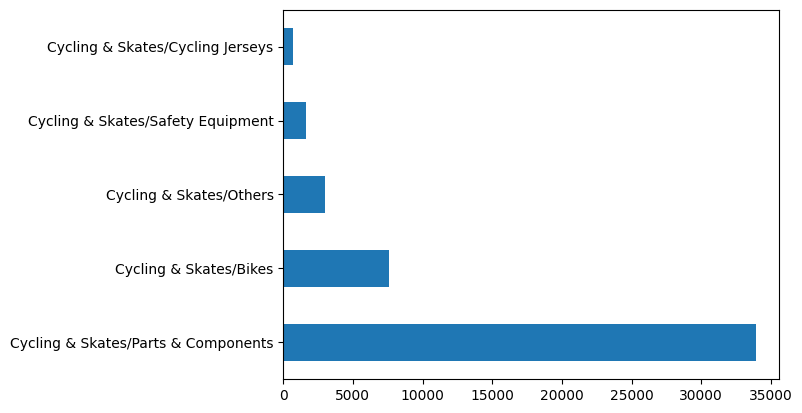

In [ ]:
df.fe_categories.value_counts().head().plot(kind='barh', ylabel='')

In [18]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [22]:
tf_idf = TfidfVectorizer(max_features=50000, min_df=2)

## Base Modeling

### Base Model Evaluation

In [948]:
##Initialize train test splits to be used for all base models

X_train, X_test, y_train, y_test = train_test_split(df['product_name'], 
                                                    df['fe_categories'], 
                                                    test_size=0.33, random_state=14)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df['fe_categories']) # For class weights
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

class_labels = np.unique(y_encoded)
class_weights = compute_class_weight(class_weight = 'balanced', classes = class_labels, y = y_encoded)
class_weight_dict = dict(zip(class_labels, class_weights))

In [277]:
%%time

X_train, X_test, y_train, y_test = train_test_split(df['product_name'], 
                                                    df['fe_categories'], 
                                                    test_size=0.33, random_state=14)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df['fe_categories'])
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

models = [
    RandomForestClassifier(random_state = 14),
    LinearSVC(random_state = 14, dual=False),
    MultinomialNB(),
    LogisticRegression(random_state = 14),
    XGBClassifier(random_state = 14,
                  objective = 'multi:softmax',
                  tree_method = 'hist',
                  device = 'cuda',
                  num_class=np.unique(y_encoded).shape[0])
]

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

cv_df = pd.DataFrame(index=range(5 * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  f1_scores = cross_val_score(model, X_train_tfidf, y_train_encoded, scoring=weighted_f1_scorer, cv=stratified_kfold)
  for fold_idx, f1_score_out in enumerate(f1_scores):
    entries.append((model_name, fold_idx, f1_score_out))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

CPU times: user 18min 4s, sys: 10min 25s, total: 28min 30s
Wall time: 10min 41s


In [278]:
mean_f1_score = cv_df.groupby('model_name').f1_score.mean()
std_f1_score = cv_df.groupby('model_name').f1_score.std()

f1 = pd.concat([mean_f1_score, std_f1_score], axis= 1, 
          ignore_index=True)
f1.columns = ['Mean F1-Score', 'Standard deviation']
f1

,Mean F1-Score,Standard deviation
model_name,,
LinearSVC,0.794682,0.004338
LogisticRegression,0.755511,0.005381
MultinomialNB,0.665578,0.004049
RandomForestClassifier,0.788467,0.004751
XGBClassifier,0.427763,0.055041


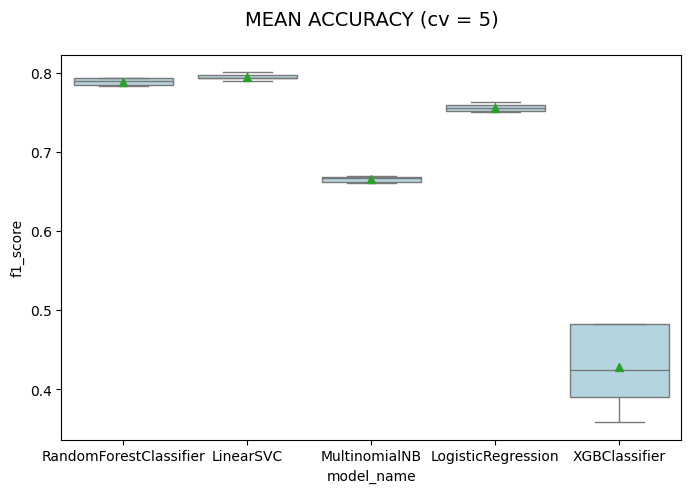

In [279]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='f1_score', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [529]:
models_list = []

def model_list_append(model_name, accuracy, precision, recall, f1_score) -> None:
    """Since df.append is not working anymore, will use this function to append to a list which will then be created into a DF"""
    model_dict = {}
    model_dict['Model_Name'] = model_name
    model_dict['Accuracy'] = accuracy
    model_dict['Precision'] = precision
    model_dict['Recall'] = recall
    model_dict['F1-Score'] = f1_score

    models_list.append(model_dict)

def model_eval(model_name_input: str, y_pred_input, y_test_input = y_test, print_results=False):
    """To give weighted metrics of model, if print == True, it will print the results. Otherwise this is just to be straight fed into model_list_append above"""
    model_name = model_name_input
    accuracy_result = accuracy_score(y_true=y_test_input, y_pred=y_pred_input)*100
    precision_result = precision_score(y_true=y_test_input, y_pred=y_pred_input, average='weighted')*100
    recall_result = recall_score(y_true=y_test_input, y_pred=y_pred_input, average='weighted')*100
    f1_result = f1_score(y_true=y_test_input, y_pred=y_pred_input, average='weighted')*100

    if print_results == True:
        print(f"-------------{model_name} Weighted scores-------------")
        print(f"Accuracy: {accuracy_result}")
        print(f"Precision: {precision_result}")
        print(f"Recall: {recall_result}")
        print(f"F1-Score: {f1_result}")
        
    else:
        return model_name, accuracy_result, precision_result, recall_result, f1_result

### LinearSVC Hyperparameter Tuning

In [309]:
%%time

# param_dist = {
#     'C': loguniform(1e-5, 100),
#     'class_weight': [None, class_weight_dict],
# }

param_dist = {}

# Create a Logistic Regression model
svc = LinearSVC(random_state = 14, dual=False, loss='squared_hinge')

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    svc,
    param_distributions=param_dist,
    n_iter=1,
    cv=stratified_kfold,
    scoring=weighted_f1_scorer,
    random_state=14,
    n_jobs=4,
)

# Perform the random search on your training data
random_search.fit(X_train_tfidf, y_train_encoded)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {}
Best Score: 0.7946812727444239
CPU times: user 25.3 s, sys: 25.1 s, total: 50.4 s
Wall time: 20.2 s


In [514]:
%%time

param_dist = {
    'C': loguniform(1e-5, 100),
    'class_weight': [None, class_weight_dict],
}

svc = LinearSVC(random_state = 14, dual=False, loss='squared_hinge')

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Create a RandomizedSearchCV object
svc_random_search = RandomizedSearchCV(
    svc,
    param_distributions=param_dist,
    n_iter=50,
    cv=stratified_kfold,
    scoring=weighted_f1_scorer,
    random_state=14,
    n_jobs=2,
)

# Perform the random search on your training data
svc_random_search.fit(X_train_tfidf, y_train_encoded)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", svc_random_search.best_params_)
print("Best Score:", svc_random_search.best_score_)

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of

Best Hyperparameters: {'C': 1.2989993092595722, 'class_weight': None}
Best Score: 0.7936280309801937
CPU times: user 48 s, sys: 45.7 s, total: 1min 33s
Wall time: 36min 25s


In [515]:
%%time

param_dist = {
}

svc = LinearSVC(random_state = 14, dual=False, loss='squared_hinge')

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Create a RandomizedSearchCV object
svc_random_search = RandomizedSearchCV(
    svc,
    param_distributions=param_dist,
    n_iter=1,
    cv=stratified_kfold,
    scoring=weighted_f1_scorer,
    random_state=14,
    n_jobs=2,
)

# Perform the random search on your training data
svc_random_search.fit(X_train_tfidf, y_train_encoded)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", svc_random_search.best_params_)
print("Best Score:", svc_random_search.best_score_)

Best Hyperparameters: {}
Best Score: 0.7946818462829899
CPU times: user 44.3 s, sys: 49.3 s, total: 1min 33s
Wall time: 40.7 s


In [533]:
%%time
svc = LinearSVC(random_state=14, dual=False, loss='squared_hinge', **svc_random_search.best_params_)

svc.fit(X_train_tfidf, y_train_encoded)

CPU times: user 37 s, sys: 38.6 s, total: 1min 15s
Wall time: 12.1 s


LinearSVC(dual=False, random_state=14)

In [534]:
valid_pred_levels = svc.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [535]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                                         precision    recall  f1-score   support

            Acrobatic & Martial Arts/Training Equipment       0.79      0.41      0.54        27
                                       Badminton/Others       0.75      0.33      0.46         9
                                      Basketball/Others       0.78      0.70      0.74        10
                                 Cycling & Skates/Bikes       0.82      0.61      0.70      2504
                       Cycling & Skates/Cycling Jerseys       0.63      0.73      0.68       218
                                Cycling & Skates/Others       0.46      0.23      0.31      1014
                    Cycling & Skates/Parts & Components       0.84      0.94      0.89     11230
                      Cycling & Skates/Safety Equipment       0.86      0.84      0.85       541
                              Cycling & Skates/Scooters       0.87      0.75      0.81       137
                             

In [536]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                              precision    recall  f1-score   support

    Acrobatic & Martial Arts       0.79      0.41      0.54        27
                   Badminton       0.75      0.33      0.46         9
                  Basketball       0.78      0.70      0.74        10
            Cycling & Skates       0.97      0.99      0.98     15652
Exercise & Fitness Equipment       0.92      0.69      0.79       241
                     Fishing       0.95      0.84      0.89       174
           Football & Futsal       0.67      0.80      0.73        10
  Kids Sports & Outdoor Play       1.00      0.99      1.00       111
          Men's Sports Shoes       0.65      0.75      0.70       147
         Outdoor & Adventure       0.89      0.69      0.78       354
            Performance Wear       0.72      0.64      0.67       515
               Racket Sports       0.74      0.34      0.46        95
                     Running       0.75      0.50      0.60        48
          Sports & 

In [537]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                                 precision    recall  f1-score   support

                    Accessories       0.78      0.54      0.64        26
                        Archery       0.93      0.93      0.93        15
           Baits, Lures & Flies       0.82      0.80      0.81        45
                          Bikes       0.82      0.61      0.70      2504
               Camping & Hiking       0.79      0.86      0.82       111
               Compression Tops       0.46      0.59      0.52        27
                Cycling Jerseys       0.63      0.73      0.68       218
     Exercise Bikes & Treamills       0.80      0.71      0.76        52
            Fishing Accessories       0.80      0.67      0.73         6
                           Golf       0.93      0.70      0.80        37
                           Hats       0.80      0.65      0.72        57
                          Hooks       0.70      0.68      0.69        38
                        Jackets       0.33      0.

In [538]:
model_eval('LinearSVC', pred_decoded, y_test, print_results=True)


-------------LinearSVC Weighted scores-------------
Accuracy: 81.01940114388248
Precision: 79.66405259382918
Recall: 81.01940114388248
F1-Score: 79.48085209936029


In [540]:
model_list_append(*model_eval('LinearSVC', pred_decoded, y_test))

In [541]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852


### Random Forest + Hyperparameter Tuning

In [545]:
# param_dist = {
#             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#             'max_features': ['log2', 'sqrt'],
#             'min_samples_leaf': [1, 2, 4],
#             'min_samples_split': [2, 5, 10],
#             'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
#             'class_weight': [None, class_weight_dict]
#             }

param_dist = {}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Create a RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=14),
    param_distributions=param_dist,
    n_iter=1, 
    cv=stratified_kfold,
    scoring=weighted_f1_scorer,
    random_state=14,
    n_jobs=4,
)

# Perform the random search on your training data
rf_random_search.fit(X_train_tfidf, y_train_encoded)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", rf_random_search.best_params_)
print("Best Score:", rf_random_search.best_score_)

Best Hyperparameters: {}
Best Score: 0.7884670121297159


In [547]:
%%time
rf = RandomForestClassifier(random_state=14, **rf_random_search.best_params_)

rf.fit(X_train_tfidf, y_train_encoded)

CPU times: user 1min 24s, sys: 1 s, total: 1min 25s
Wall time: 1min 25s


RandomForestClassifier(random_state=14)

In [548]:
valid_pred_levels = rf.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [549]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                         precision    recall  f1-score   support

            Acrobatic & Martial Arts/Training Equipment       0.63      0.44      0.52        27
                                       Badminton/Others       1.00      0.11      0.20         9
                                      Basketball/Others       0.60      0.30      0.40        10
                                 Cycling & Skates/Bikes       0.87      0.61      0.72      2504
                       Cycling & Skates/Cycling Jerseys       0.66      0.80      0.72       218
                                Cycling & Skates/Others       0.51      0.23      0.32      1014
                    Cycling & Skates/Parts & Components       0.82      0.96      0.89     11230
                      Cycling & Skates/Safety Equipment       0.89      0.85      0.87       541
                              Cycling & Skates/Scooters       0.90      0.71      0.79       137
                             

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [550]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                              precision    recall  f1-score   support

    Acrobatic & Martial Arts       0.63      0.44      0.52        27
                   Badminton       1.00      0.11      0.20         9
                  Basketball       0.60      0.30      0.40        10
            Cycling & Skates       0.96      0.99      0.97     15652
Exercise & Fitness Equipment       0.91      0.60      0.72       241
                     Fishing       0.96      0.85      0.90       174
           Football & Futsal       0.44      0.80      0.57        10
  Kids Sports & Outdoor Play       1.00      0.99      1.00       111
          Men's Sports Shoes       0.71      0.69      0.70       147
         Outdoor & Adventure       0.90      0.61      0.73       354
            Performance Wear       0.77      0.58      0.66       515
               Racket Sports       0.62      0.25      0.36        95
                     Running       0.81      0.44      0.57        48
          Sports & 

In [551]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

                    Accessories       0.69      0.35      0.46        26
                        Archery       1.00      0.53      0.70        15
           Baits, Lures & Flies       0.79      0.76      0.77        45
                          Bikes       0.87      0.61      0.72      2504
               Camping & Hiking       0.73      0.81      0.77       111
               Compression Tops       0.67      0.37      0.48        27
                Cycling Jerseys       0.66      0.80      0.72       218
     Exercise Bikes & Treamills       0.76      0.62      0.68        52
            Fishing Accessories       0.00      0.00      0.00         6
                           Golf       0.93      0.70      0.80        37
                           Hats       0.91      0.35      0.51        57
                          Hooks       0.67      0.58      0.62        38
                        Jackets       0.00      0.

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [555]:
model_eval('Random Forest', pred_decoded, y_test, print_results=True)


/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------Random Forest Weighted scores-------------
Accuracy: 81.18201188740608
Precision: 80.12076338784956
Recall: 81.18201188740608
F1-Score: 79.3113019591088


In [553]:
model_list_append(*model_eval('Random Forest', pred_decoded, y_test))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [556]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302


### Logistic Regression + Hyperparameter Tuning

In [558]:
%%time

param_dist = {
    'multi_class': ['multinomial'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'C': loguniform(1e-5, 100),
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

logit_random_search = RandomizedSearchCV(
    LogisticRegression(random_state=14, max_iter=500),
    param_distributions=param_dist,
    n_iter=10,
    cv=stratified_kfold,
    scoring=weighted_f1_scorer,
    random_state=14,
    n_jobs=4,
)

logit_random_search.fit(X_train_tfidf, y_train)

print("Best Hyperparameters:", logit_random_search.best_params_)
print("Best Score:", logit_random_search.best_score_)

Best Hyperparameters: {'C': 0.41076577364057054, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best Score: 0.7206104455276547
CPU times: user 2min 53s, sys: 2min 39s, total: 5min 32s
Wall time: 6min 27s


In [559]:
%%time

param_dist = {}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

logit_random_search = RandomizedSearchCV(
    LogisticRegression(random_state=14, max_iter=500),
    param_distributions=param_dist,
    n_iter=1,
    cv=stratified_kfold,
    scoring=weighted_f1_scorer,
    random_state=14,
    n_jobs=4,
)

logit_random_search.fit(X_train_tfidf, y_train)

print("Best Hyperparameters:", logit_random_search.best_params_)
print("Best Score:", logit_random_search.best_score_)

Best Hyperparameters: {}
Best Score: 0.7554194746131024
CPU times: user 3min 54s, sys: 3min 32s, total: 7min 26s
Wall time: 3min 32s


In [560]:
%%time
logit = LogisticRegression(random_state=14, max_iter=500, **logit_random_search.best_params_)

logit.fit(X_train_tfidf, y_train_encoded)

CPU times: user 3min 51s, sys: 3min 31s, total: 7min 22s
Wall time: 1min 14s


LogisticRegression(max_iter=500, random_state=14)

In [561]:
valid_pred_levels = logit.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [562]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                         precision    recall  f1-score   support

            Acrobatic & Martial Arts/Training Equipment       0.77      0.37      0.50        27
                                       Badminton/Others       0.00      0.00      0.00         9
                                      Basketball/Others       0.00      0.00      0.00        10
                                 Cycling & Skates/Bikes       0.84      0.58      0.69      2504
                       Cycling & Skates/Cycling Jerseys       0.55      0.68      0.61       218
                                Cycling & Skates/Others       0.45      0.17      0.24      1014
                    Cycling & Skates/Parts & Components       0.80      0.96      0.87     11230
                      Cycling & Skates/Safety Equipment       0.87      0.80      0.84       541
                              Cycling & Skates/Scooters       0.88      0.67      0.76       137
                             

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [563]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

    Acrobatic & Martial Arts       0.77      0.37      0.50        27
                   Badminton       0.00      0.00      0.00         9
                  Basketball       0.00      0.00      0.00        10
            Cycling & Skates       0.94      0.99      0.97     15652
Exercise & Fitness Equipment       0.94      0.42      0.58       241
                     Fishing       0.96      0.70      0.81       174
           Football & Futsal       1.00      0.30      0.46        10
  Kids Sports & Outdoor Play       1.00      0.98      0.99       111
          Men's Sports Shoes       0.70      0.69      0.70       147
         Outdoor & Adventure       0.89      0.46      0.61       354
            Performance Wear       0.75      0.53      0.62       515
               Racket Sports       0.86      0.13      0.22        95
                     Running       0.88      0.46      0.60        48
          Sports & 

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [564]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

                    Accessories       0.89      0.31      0.46        26
                        Archery       1.00      0.13      0.24        15
           Baits, Lures & Flies       0.88      0.64      0.74        45
                          Bikes       0.84      0.58      0.69      2504
               Camping & Hiking       0.80      0.69      0.74       111
               Compression Tops       0.33      0.07      0.12        27
                Cycling Jerseys       0.55      0.68      0.61       218
     Exercise Bikes & Treamills       0.73      0.62      0.67        52
            Fishing Accessories       0.00      0.00      0.00         6
                           Golf       0.91      0.27      0.42        37
                           Hats       0.85      0.40      0.55        57
                          Hooks       0.57      0.45      0.50        38
                        Jackets       0.00      0.

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [565]:
model_eval('Logistic Regression', pred_decoded, y_test, print_results=True)


/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------Logistic Regression Weighted scores-------------
Accuracy: 79.14096669283391
Precision: 77.25628208149732
Recall: 79.14096669283391
F1-Score: 76.48790835386819


In [567]:
model_list_append(*model_eval('Logistic Regression', pred_decoded, y_test))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [568]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908


## Reduced Approach to modeling

In [570]:
drop_classes_to_reduce = df['fe_categories'].value_counts()[df['fe_categories'].value_counts() < 450].index.to_list()

reduced_df = df[df['fe_categories'].isin(drop_classes_to_reduce) == False]

##Initialize train test splits to be used for all reduced models

X_train, X_test, y_train, y_test = train_test_split(reduced_df['product_name'], 
                                                    reduced_df['fe_categories'], 
                                                    test_size=0.33, random_state=14)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(reduced_df['fe_categories']) # For class weights
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

class_labels = np.unique(y_encoded)
class_weights = compute_class_weight(class_weight = 'balanced', classes = class_labels, y = y_encoded)
class_weight_dict = dict(zip(class_labels, class_weights))

### LinearSVC Reduced

In [571]:
%%time
svc_reduced = LinearSVC(random_state=14, dual = False, loss='squared_hinge', **svc_random_search.best_params_)

svc_reduced.fit(X_train_tfidf, y_train_encoded)

CPU times: user 1.41 s, sys: 2.82 ms, total: 1.41 s
Wall time: 1.42 s


LinearSVC(dual=False, random_state=14)

In [572]:
valid_pred_levels = svc_reduced.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [573]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                     precision    recall  f1-score   support

             Cycling & Skates/Bikes       0.82      0.62      0.71      2535
   Cycling & Skates/Cycling Jerseys       0.71      0.78      0.75       213
            Cycling & Skates/Others       0.56      0.27      0.36       999
Cycling & Skates/Parts & Components       0.85      0.95      0.90     11184
  Cycling & Skates/Safety Equipment       0.91      0.85      0.88       538
          Cycling & Skates/Scooters       0.84      0.72      0.77       134
          Men's Sports Shoes/Others       0.73      0.77      0.75       146
              Performance Wear/Sets       0.73      0.70      0.71       179
                Sports Wear/Jerseys       0.84      0.64      0.73       168
                Water Sports/Others       0.99      0.86      0.92       165

                           accuracy                           0.84     16261
                          macro avg       0.80      0.71      0.75     162

In [574]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                    precision    recall  f1-score   support

  Cycling & Skates       0.99      0.99      0.99     15603
Men's Sports Shoes       0.73      0.77      0.75       146
  Performance Wear       0.73      0.70      0.71       179
       Sports Wear       0.84      0.64      0.73       168
      Water Sports       0.99      0.86      0.92       165

          accuracy                           0.98     16261
         macro avg       0.86      0.79      0.82     16261
      weighted avg       0.98      0.98      0.98     16261



In [575]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                    precision    recall  f1-score   support

             Bikes       0.82      0.62      0.71      2535
   Cycling Jerseys       0.71      0.78      0.75       213
           Jerseys       0.84      0.64      0.73       168
            Others       0.70      0.42      0.52      1310
Parts & Components       0.85      0.95      0.90     11184
  Safety Equipment       0.91      0.85      0.88       538
          Scooters       0.84      0.72      0.77       134
              Sets       0.73      0.70      0.71       179

          accuracy                           0.84     16261
         macro avg       0.80      0.71      0.75     16261
      weighted avg       0.84      0.84      0.83     16261



In [576]:
model_eval('LinearSVC Reduced', pred_decoded, y_test, print_results=True)


-------------LinearSVC Reduced Weighted scores-------------
Accuracy: 84.02312280917533
Precision: 82.98438730541831
Recall: 84.02312280917533
F1-Score: 82.7760582501433


In [577]:
model_list_append(*model_eval('LinearSVC Reduced', pred_decoded, y_test))

In [578]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058


### Random Forest Reduced

In [579]:
%%time
rf_reduced = RandomForestClassifier(random_state=14, **rf_random_search.best_params_)

rf_reduced.fit(X_train_tfidf, y_train_encoded)

CPU times: user 1min 4s, sys: 102 ms, total: 1min 4s
Wall time: 1min 4s


RandomForestClassifier(random_state=14)

In [580]:
valid_pred_levels = rf_reduced.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [581]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                     precision    recall  f1-score   support

             Cycling & Skates/Bikes       0.87      0.62      0.72      2535
   Cycling & Skates/Cycling Jerseys       0.71      0.83      0.76       213
            Cycling & Skates/Others       0.65      0.25      0.36       999
Cycling & Skates/Parts & Components       0.85      0.97      0.91     11184
  Cycling & Skates/Safety Equipment       0.92      0.85      0.88       538
          Cycling & Skates/Scooters       0.85      0.72      0.78       134
          Men's Sports Shoes/Others       0.77      0.72      0.74       146
              Performance Wear/Sets       0.83      0.56      0.67       179
                Sports Wear/Jerseys       0.82      0.64      0.72       168
                Water Sports/Others       0.99      0.78      0.87       165

                           accuracy                           0.85     16261
                          macro avg       0.83      0.69      0.74     162

In [582]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                    precision    recall  f1-score   support

  Cycling & Skates       0.99      1.00      0.99     15603
Men's Sports Shoes       0.77      0.72      0.74       146
  Performance Wear       0.83      0.56      0.67       179
       Sports Wear       0.82      0.64      0.72       168
      Water Sports       0.99      0.78      0.87       165

          accuracy                           0.98     16261
         macro avg       0.88      0.74      0.80     16261
      weighted avg       0.98      0.98      0.98     16261



In [583]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                    precision    recall  f1-score   support

             Bikes       0.87      0.62      0.72      2535
   Cycling Jerseys       0.71      0.83      0.76       213
           Jerseys       0.82      0.64      0.72       168
            Others       0.77      0.38      0.51      1310
Parts & Components       0.85      0.97      0.91     11184
  Safety Equipment       0.92      0.85      0.88       538
          Scooters       0.85      0.72      0.78       134
              Sets       0.83      0.56      0.67       179

          accuracy                           0.85     16261
         macro avg       0.83      0.70      0.74     16261
      weighted avg       0.85      0.85      0.84     16261



In [585]:
model_eval('Random Forest Reduced', pred_decoded, y_test, print_results=True)


-------------Random Forest Reduced Weighted scores-------------
Accuracy: 84.85333005350225
Precision: 84.21234099224901
Recall: 84.85333005350225
F1-Score: 83.37929908701456


In [586]:
model_list_append(*model_eval('Random Forest Reduced', pred_decoded, y_test))

In [587]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299


### Logistic Regression Reduced

In [ ]:
%%time
logit_reduced = LogisticRegression(random_state=14, max_iter=500, **logit_random_search.best_params_)

logit_reduced.fit(X_train_tfidf, y_train_encoded)

CPU times: user 1min 1s, sys: 1min 22s, total: 2min 24s
Wall time: 21.4 s


LogisticRegression(max_iter=500, random_state=14)

In [ ]:
valid_pred_levels = logit_reduced.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [ ]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                     precision    recall  f1-score   support

             Cycling & Skates/Bikes       0.86      0.60      0.70      2535
   Cycling & Skates/Cycling Jerseys       0.70      0.81      0.75       213
            Cycling & Skates/Others       0.57      0.19      0.29       999
Cycling & Skates/Parts & Components       0.84      0.96      0.90     11184
  Cycling & Skates/Safety Equipment       0.91      0.80      0.85       538
          Cycling & Skates/Scooters       0.81      0.59      0.68       134
          Men's Sports Shoes/Others       0.78      0.70      0.74       146
              Performance Wear/Sets       0.76      0.58      0.66       179
                Sports Wear/Jerseys       0.89      0.62      0.73       168
                Water Sports/Others       1.00      0.60      0.75       165

                           accuracy                           0.83     16261
                          macro avg       0.81      0.65      0.71     162

In [ ]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                    precision    recall  f1-score   support

  Cycling & Skates       0.99      1.00      0.99     15603
Men's Sports Shoes       0.78      0.70      0.74       146
  Performance Wear       0.76      0.58      0.66       179
       Sports Wear       0.89      0.62      0.73       168
      Water Sports       1.00      0.60      0.75       165

          accuracy                           0.98     16261
         macro avg       0.88      0.70      0.77     16261
      weighted avg       0.98      0.98      0.98     16261



In [ ]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                    precision    recall  f1-score   support

             Bikes       0.86      0.60      0.70      2535
   Cycling Jerseys       0.70      0.81      0.75       213
           Jerseys       0.89      0.62      0.73       168
            Others       0.74      0.32      0.45      1310
Parts & Components       0.84      0.96      0.90     11184
  Safety Equipment       0.91      0.80      0.85       538
          Scooters       0.81      0.59      0.68       134
              Sets       0.76      0.58      0.66       179

          accuracy                           0.84     16261
         macro avg       0.81      0.66      0.72     16261
      weighted avg       0.83      0.84      0.82     16261



In [ ]:
model_eval('Logistic Regression Reduced', pred_decoded, y_test, print_results=True)


-------------Logistic Regression Reduced Weighted scores-------------
Accuracy: 83.48195067954
Precision: 82.57564208765751
Recall: 83.48195067954
F1-Score: 81.68427422296458


In [ ]:
model_list_append(*model_eval('Logistic Regression Reduced', pred_decoded, y_test))

In [ ]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274


## No Others Modeling

In [632]:
drop_classes_to_reduce = df['fe_categories'].value_counts()[df['fe_categories'].value_counts() < 20].index.to_list()

df = df[df['fe_categories'].isin(drop_classes_to_reduce) == False]

df_no_others = df[df['fe_category2'] != 'Others']

##Initialize train test splits to be used for all reduced no other models

X_train, X_test, y_train, y_test = train_test_split(df_no_others['product_name'], 
                                                    df_no_others['fe_categories'], 
                                                    test_size=0.33, random_state=14)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df_no_others['fe_categories']) # For class weights
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

class_labels = np.unique(y_encoded)
class_weights = compute_class_weight(class_weight = 'balanced', classes = class_labels, y = y_encoded)
class_weight_dict = dict(zip(class_labels, class_weights))

### Linear SVC No Others

In [617]:
%%time
svc_no_others = LinearSVC(random_state=14, dual = False,  **svc_random_search.best_params_)

svc_no_others.fit(X_train_tfidf, y_train_encoded)

CPU times: user 20.8 s, sys: 21.8 s, total: 42.6 s
Wall time: 6.54 s


LinearSVC(dual=False, random_state=14)

In [618]:
valid_pred_levels = svc_no_others.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [619]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                                         precision    recall  f1-score   support

            Acrobatic & Martial Arts/Training Equipment       0.85      0.34      0.49        32
                                 Cycling & Skates/Bikes       0.82      0.61      0.70      2526
                       Cycling & Skates/Cycling Jerseys       0.64      0.76      0.69       213
                    Cycling & Skates/Parts & Components       0.89      0.96      0.92     11173
                      Cycling & Skates/Safety Equipment       0.92      0.84      0.88       522
                              Cycling & Skates/Scooters       0.87      0.83      0.85       155
                                Cycling & Skates/Skates       0.83      0.29      0.43        17
               Exercise & Fitness Equipment/Accessories       0.80      0.89      0.84        27
                   Exercise & Fitness Equipment/Archery       0.93      0.87      0.90        15
Exercise & Fitness Equipment/

In [620]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                              precision    recall  f1-score   support

    Acrobatic & Martial Arts       0.85      0.34      0.49        32
            Cycling & Skates       0.98      0.99      0.98     14606
Exercise & Fitness Equipment       0.88      0.73      0.79       204
                     Fishing       0.98      0.79      0.88       134
  Kids Sports & Outdoor Play       1.00      1.00      1.00        99
          Men's Sports Shoes       1.00      1.00      1.00        13
         Outdoor & Adventure       0.91      0.67      0.78       243
            Performance Wear       0.78      0.75      0.77       397
               Racket Sports       1.00      0.69      0.82        26
                     Running       0.88      0.62      0.73        45
          Sports & Beachwear       1.00      0.67      0.80        24
                 Sports Wear       0.78      0.65      0.71       201
          Stick & Ball Games       0.97      0.79      0.87        38
                Wat

In [621]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                                 precision    recall  f1-score   support

                    Accessories       0.80      0.89      0.84        27
                        Archery       0.93      0.87      0.90        15
           Baits, Lures & Flies       0.79      0.77      0.78        43
                          Bikes       0.82      0.61      0.70      2526
               Camping & Hiking       0.92      0.85      0.88       106
               Compression Tops       0.29      0.27      0.28        22
                Cycling Jerseys       0.64      0.76      0.69       213
     Exercise Bikes & Treamills       0.79      0.73      0.76        60
            Fishing Accessories       0.80      0.36      0.50        11
                           Golf       0.97      0.79      0.87        38
                           Hats       0.85      0.76      0.81        68
                          Hooks       0.70      0.57      0.63        54
                        Jackets       0.71      0.

In [623]:
model_eval('LinearSVC No Others', pred_decoded, y_test, print_results=True)

-------------LinearSVC No Others Weighted scores-------------
Accuracy: 87.1104199066874
Precision: 86.72173785011833
Recall: 87.1104199066874
F1-Score: 86.37161748169547


In [628]:
model_list_append(*model_eval('LinearSVC No Others', pred_decoded, y_test))

In [629]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274
6,LinearSVC No Others,87.110420,86.721738,87.110420,86.371617


### Random Forest No Others

In [633]:
%%time
rf_no_others = RandomForestClassifier(random_state=14, **rf_random_search.best_params_)

rf_no_others.fit(X_train_tfidf, y_train_encoded)

CPU times: user 57.6 s, sys: 551 ms, total: 58.1 s
Wall time: 58.3 s


RandomForestClassifier(random_state=14)

In [634]:
valid_pred_levels = rf_no_others.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [635]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                                         precision    recall  f1-score   support

            Acrobatic & Martial Arts/Training Equipment       0.90      0.28      0.43        32
                                 Cycling & Skates/Bikes       0.87      0.60      0.71      2526
                       Cycling & Skates/Cycling Jerseys       0.66      0.79      0.72       213
                    Cycling & Skates/Parts & Components       0.88      0.97      0.92     11173
                      Cycling & Skates/Safety Equipment       0.92      0.85      0.89       522
                              Cycling & Skates/Scooters       0.87      0.75      0.80       155
                                Cycling & Skates/Skates       1.00      0.18      0.30        17
               Exercise & Fitness Equipment/Accessories       0.73      0.59      0.65        27
                   Exercise & Fitness Equipment/Archery       0.82      0.60      0.69        15
Exercise & Fitness Equipment/

In [636]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                              precision    recall  f1-score   support

    Acrobatic & Martial Arts       0.90      0.28      0.43        32
            Cycling & Skates       0.97      0.99      0.98     14606
Exercise & Fitness Equipment       0.89      0.64      0.74       204
                     Fishing       0.93      0.79      0.85       134
  Kids Sports & Outdoor Play       1.00      1.00      1.00        99
          Men's Sports Shoes       1.00      1.00      1.00        13
         Outdoor & Adventure       0.92      0.65      0.76       243
            Performance Wear       0.81      0.65      0.72       397
               Racket Sports       1.00      0.73      0.84        26
                     Running       1.00      0.58      0.73        45
          Sports & Beachwear       1.00      0.42      0.59        24
                 Sports Wear       0.77      0.61      0.68       201
          Stick & Ball Games       0.93      0.74      0.82        38
                Wat

In [637]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                                 precision    recall  f1-score   support

                    Accessories       0.73      0.59      0.65        27
                        Archery       0.82      0.60      0.69        15
           Baits, Lures & Flies       0.77      0.77      0.77        43
                          Bikes       0.87      0.60      0.71      2526
               Camping & Hiking       0.81      0.85      0.83       106
               Compression Tops       0.29      0.32      0.30        22
                Cycling Jerseys       0.66      0.79      0.72       213
     Exercise Bikes & Treamills       0.85      0.68      0.76        60
            Fishing Accessories       0.75      0.27      0.40        11
                           Golf       0.93      0.74      0.82        38
                           Hats       1.00      0.34      0.51        68
                          Hooks       0.67      0.61      0.64        54
                        Jackets       0.00      0.

In [639]:
model_eval('Random Forest No Others', pred_decoded, y_test, print_results=True)

-------------Random Forest No Others Weighted scores-------------
Accuracy: 87.1104199066874
Precision: 87.01884633552693
Recall: 87.1104199066874
F1-Score: 86.11605947116982


In [640]:
model_list_append(*model_eval('Random Forest No Others', pred_decoded, y_test))

In [641]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274
6,LinearSVC No Others,87.110420,86.721738,87.110420,86.371617
7,Random Forest No Others,87.110420,87.018846,87.110420,86.116059


### Logisting Regression No Others

In [642]:
%%time
logit_no_others = LogisticRegression(random_state=14, max_iter=500, **logit_random_search.best_params_)

logit_no_others.fit(X_train_tfidf, y_train_encoded)

CPU times: user 2min 18s, sys: 2min 25s, total: 4min 44s
Wall time: 45.9 s


LogisticRegression(max_iter=500, random_state=14)

In [643]:
valid_pred_levels = logit_no_others.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [644]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                         precision    recall  f1-score   support

            Acrobatic & Martial Arts/Training Equipment       1.00      0.25      0.40        32
                                 Cycling & Skates/Bikes       0.84      0.57      0.68      2526
                       Cycling & Skates/Cycling Jerseys       0.62      0.77      0.68       213
                    Cycling & Skates/Parts & Components       0.86      0.97      0.91     11173
                      Cycling & Skates/Safety Equipment       0.92      0.79      0.85       522
                              Cycling & Skates/Scooters       0.86      0.68      0.76       155
                                Cycling & Skates/Skates       0.00      0.00      0.00        17
               Exercise & Fitness Equipment/Accessories       0.67      0.37      0.48        27
                   Exercise & Fitness Equipment/Archery       0.75      0.20      0.32        15
Exercise & Fitness Equipment/

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [645]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

    Acrobatic & Martial Arts       1.00      0.25      0.40        32
            Cycling & Skates       0.96      1.00      0.98     14606
Exercise & Fitness Equipment       0.93      0.49      0.64       204
                     Fishing       0.99      0.61      0.76       134
  Kids Sports & Outdoor Play       0.98      1.00      0.99        99
          Men's Sports Shoes       1.00      0.69      0.82        13
         Outdoor & Adventure       0.93      0.46      0.62       243
            Performance Wear       0.81      0.61      0.70       397
               Racket Sports       1.00      0.38      0.56        26
                     Running       1.00      0.44      0.62        45
          Sports & Beachwear       1.00      0.25      0.40        24
                 Sports Wear       0.81      0.56      0.66       201
          Stick & Ball Games       1.00      0.29      0.45        38
                Wat

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [646]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

                    Accessories       0.67      0.37      0.48        27
                        Archery       0.75      0.20      0.32        15
           Baits, Lures & Flies       0.83      0.70      0.76        43
                          Bikes       0.84      0.57      0.68      2526
               Camping & Hiking       0.84      0.64      0.73       106
               Compression Tops       0.29      0.18      0.22        22
                Cycling Jerseys       0.62      0.77      0.68       213
     Exercise Bikes & Treamills       0.75      0.67      0.71        60
            Fishing Accessories       1.00      0.18      0.31        11
                           Golf       1.00      0.29      0.45        38
                           Hats       0.82      0.49      0.61        68
                          Hooks       0.61      0.37      0.46        54
                        Jackets       0.00      0.

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [648]:
model_eval('Logistic Regression No Others', pred_decoded, y_test, print_results=True)


/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------Logistic Regression No Others Weighted scores-------------
Accuracy: 85.25660964230171
Precision: 84.5953170785162
Recall: 85.25660964230171
F1-Score: 83.76791148654141


In [649]:
model_list_append(*model_eval('Logistic Regression No Others', pred_decoded, y_test))

/home/tooshy/Documents/projects/gitprojects/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [650]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274
6,LinearSVC No Others,87.110420,86.721738,87.110420,86.371617
7,Random Forest No Others,87.110420,87.018846,87.110420,86.116059
8,Logistic Regression No Others,85.256610,84.595317,85.256610,83.767911


## No Others Reduced Modeling

In [971]:
drop_classes_to_reduce = df['fe_categories'].value_counts()[df['fe_categories'].value_counts() < 450].index.to_list()

reduced_df = df[df['fe_categories'].isin(drop_classes_to_reduce) == False]

reduced_df_no_others = reduced_df[reduced_df['fe_category2'] != 'Others']

##Initialize train test splits to be used for all reduced no other models

X_train, X_test, y_train, y_test = train_test_split(reduced_df_no_others['product_name'], 
                                                    reduced_df_no_others['fe_categories'], 
                                                    test_size=0.33, random_state=14)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(reduced_df_no_others['fe_categories']) # For class weights
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

class_labels = np.unique(y_encoded)
class_weights = compute_class_weight(class_weight = 'balanced', classes = class_labels, y = y_encoded)
class_weight_dict = dict(zip(class_labels, class_weights))

### LinearSVC No Others Reduced

In [652]:
%%time
svc_no_others_reduced = LinearSVC(random_state=14, dual = False,  **svc_random_search.best_params_)

svc_no_others_reduced.fit(X_train_tfidf, y_train_encoded)

CPU times: user 663 ms, sys: 0 ns, total: 663 ms
Wall time: 663 ms


LinearSVC(dual=False, random_state=14)

In [653]:
valid_pred_levels = svc_no_others_reduced.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [654]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                     precision    recall  f1-score   support

             Cycling & Skates/Bikes       0.85      0.62      0.72      2554
   Cycling & Skates/Cycling Jerseys       0.69      0.71      0.70       214
Cycling & Skates/Parts & Components       0.90      0.97      0.94     11129
  Cycling & Skates/Safety Equipment       0.92      0.82      0.87       555
          Cycling & Skates/Scooters       0.87      0.83      0.85       152
              Performance Wear/Sets       0.70      0.66      0.68       176
                Sports Wear/Jerseys       0.77      0.66      0.71       154

                           accuracy                           0.89     14934
                          macro avg       0.82      0.75      0.78     14934
                       weighted avg       0.89      0.89      0.89     14934



In [655]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                  precision    recall  f1-score   support

Cycling & Skates       0.99      1.00      0.99     14604
Performance Wear       0.70      0.66      0.68       176
     Sports Wear       0.77      0.66      0.71       154

        accuracy                           0.99     14934
       macro avg       0.82      0.77      0.80     14934
    weighted avg       0.99      0.99      0.99     14934



In [656]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                    precision    recall  f1-score   support

             Bikes       0.85      0.62      0.72      2554
   Cycling Jerseys       0.69      0.71      0.70       214
           Jerseys       0.77      0.66      0.71       154
Parts & Components       0.90      0.97      0.94     11129
  Safety Equipment       0.92      0.82      0.87       555
          Scooters       0.87      0.83      0.85       152
              Sets       0.70      0.66      0.68       176

          accuracy                           0.89     14934
         macro avg       0.82      0.75      0.78     14934
      weighted avg       0.89      0.89      0.89     14934



In [659]:
model_eval('LinearSVC No Others Reduced', pred_decoded, y_test, print_results=True)


-------------LinearSVC No Others Reduced Weighted scores-------------
Accuracy: 89.17905450649525
Precision: 88.91374064520821
Recall: 89.17905450649525
F1-Score: 88.62191560968327


In [666]:
model_list_append(*model_eval('LinearSVC No Others Reduced', pred_decoded, y_test))

In [667]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274
6,LinearSVC No Others,87.110420,86.721738,87.110420,86.371617
7,Random Forest No Others,87.110420,87.018846,87.110420,86.116059
8,Logistic Regression No Others,85.256610,84.595317,85.256610,83.767911
9,LinearSVC No Others Reduced,89.179055,88.913741,89.179055,88.621916


### Random Forest No Others Reduced

In [705]:
%%time
rf_no_others_reduced = RandomForestClassifier(random_state=14, **rf_random_search.best_params_)

rf_no_others_reduced.fit(X_train_tfidf, y_train_encoded)

CPU times: user 40.6 s, sys: 69.5 ms, total: 40.7 s
Wall time: 40.7 s


RandomForestClassifier(random_state=14)

In [706]:
valid_pred_levels = rf_no_others_reduced.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [707]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                     precision    recall  f1-score   support

             Cycling & Skates/Bikes       0.88      0.62      0.73      2554
   Cycling & Skates/Cycling Jerseys       0.71      0.79      0.75       214
Cycling & Skates/Parts & Components       0.90      0.98      0.94     11129
  Cycling & Skates/Safety Equipment       0.93      0.84      0.89       555
          Cycling & Skates/Scooters       0.87      0.76      0.81       152
              Performance Wear/Sets       0.82      0.61      0.70       176
                Sports Wear/Jerseys       0.82      0.58      0.68       154

                           accuracy                           0.90     14934
                          macro avg       0.85      0.74      0.78     14934
                       weighted avg       0.90      0.90      0.89     14934



In [708]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                  precision    recall  f1-score   support

Cycling & Skates       0.99      1.00      1.00     14604
Performance Wear       0.82      0.61      0.70       176
     Sports Wear       0.82      0.58      0.68       154

        accuracy                           0.99     14934
       macro avg       0.88      0.73      0.79     14934
    weighted avg       0.99      0.99      0.99     14934



In [709]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                    precision    recall  f1-score   support

             Bikes       0.88      0.62      0.73      2554
   Cycling Jerseys       0.71      0.79      0.75       214
           Jerseys       0.82      0.58      0.68       154
Parts & Components       0.90      0.98      0.94     11129
  Safety Equipment       0.93      0.84      0.89       555
          Scooters       0.87      0.76      0.81       152
              Sets       0.82      0.61      0.70       176

          accuracy                           0.90     14934
         macro avg       0.85      0.74      0.78     14934
      weighted avg       0.90      0.90      0.89     14934



In [710]:
model_eval('Random Forest No Others Reduced', pred_decoded, y_test, print_results=True)

-------------Random Forest No Others Reduced Weighted scores-------------
Accuracy: 89.74822552564618
Precision: 89.63447738203757
Recall: 89.74822552564618
F1-Score: 89.11610504486305


In [676]:
model_list_append(*model_eval('Random Forest No Others Reduced', pred_decoded, y_test))

In [677]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274
6,LinearSVC No Others,87.110420,86.721738,87.110420,86.371617
7,Random Forest No Others,87.110420,87.018846,87.110420,86.116059
8,Logistic Regression No Others,85.256610,84.595317,85.256610,83.767911
9,LinearSVC No Others Reduced,89.179055,88.913741,89.179055,88.621916


### Logistic Regression No Others Reduced

In [678]:
%%time
logit_no_others_reduced = LogisticRegression(random_state=14, max_iter=500, **logit_random_search.best_params_)

logit_no_others_reduced.fit(X_train_tfidf, y_train_encoded)

CPU times: user 30.3 s, sys: 44 s, total: 1min 14s
Wall time: 10.8 s


LogisticRegression(max_iter=500, random_state=14)

In [679]:
valid_pred_levels = logit_no_others_reduced.predict(X_test_tfidf)
y_test_eval = pd.Series(y_test).apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

pred_decoded = label_encoder.inverse_transform(valid_pred_levels)
valid_pred_level_1 = [el.split('/')[0] for el in pred_decoded]
valid_pred_level_2 = [el.split('/')[1] for el in pred_decoded]

In [680]:
print(classification_report(
    y_true=y_test, 
    y_pred=pred_decoded))

                                     precision    recall  f1-score   support

             Cycling & Skates/Bikes       0.88      0.58      0.70      2554
   Cycling & Skates/Cycling Jerseys       0.67      0.72      0.70       214
Cycling & Skates/Parts & Components       0.89      0.98      0.93     11129
  Cycling & Skates/Safety Equipment       0.92      0.78      0.84       555
          Cycling & Skates/Scooters       0.85      0.64      0.73       152
              Performance Wear/Sets       0.75      0.55      0.63       176
                Sports Wear/Jerseys       0.79      0.58      0.67       154

                           accuracy                           0.88     14934
                          macro avg       0.82      0.69      0.74     14934
                       weighted avg       0.88      0.88      0.88     14934



In [681]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=valid_pred_level_1))

                  precision    recall  f1-score   support

Cycling & Skates       0.99      1.00      0.99     14604
Performance Wear       0.75      0.55      0.63       176
     Sports Wear       0.79      0.58      0.67       154

        accuracy                           0.99     14934
       macro avg       0.84      0.71      0.77     14934
    weighted avg       0.99      0.99      0.99     14934



In [682]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=valid_pred_level_2))

                    precision    recall  f1-score   support

             Bikes       0.88      0.58      0.70      2554
   Cycling Jerseys       0.67      0.72      0.70       214
           Jerseys       0.79      0.58      0.67       154
Parts & Components       0.89      0.98      0.93     11129
  Safety Equipment       0.92      0.78      0.84       555
          Scooters       0.85      0.64      0.73       152
              Sets       0.75      0.55      0.63       176

          accuracy                           0.88     14934
         macro avg       0.82      0.69      0.74     14934
      weighted avg       0.88      0.88      0.88     14934



In [683]:
model_eval('Logistic Regression No Others Reduced', pred_decoded, y_test, print_results=True)


-------------Logistic Regression No Others Reduced Weighted scores-------------
Accuracy: 88.48935315387706
Precision: 88.36520775943696
Recall: 88.48935315387706
F1-Score: 87.66839262034706


In [684]:
model_list_append(*model_eval('Logistic Regression No Others Reduced', pred_decoded, y_test))

In [685]:
pd.DataFrame.from_records(models_list)

,Model_Name,Accuracy,Precision,Recall,F1-Score
0,LinearSVC,81.019401,79.664053,81.019401,79.480852
1,Random Forest,81.182012,80.120763,81.182012,79.311302
2,Logistic Regression,79.140967,77.256282,79.140967,76.487908
3,LinearSVC Reduced,84.023123,82.984387,84.023123,82.776058
4,Random Forest Reduced,84.853330,84.212341,84.853330,83.379299
5,Logistic Regression Reduced,83.481951,82.575642,83.481951,81.684274
6,LinearSVC No Others,87.110420,86.721738,87.110420,86.371617
7,Random Forest No Others,87.110420,87.018846,87.110420,86.116059
8,Logistic Regression No Others,85.256610,84.595317,85.256610,83.767911
9,LinearSVC No Others Reduced,89.179055,88.913741,89.179055,88.621916


## Model Evaluation

### ROC-AUC Curve

In [734]:
rf_no_others_reduced_pred = rf_no_others_reduced.predict(X_test_tfidf)

In [729]:
rf_no_others_reduced_predproba = rf_no_others_reduced.predict_proba(X_test_tfidf)

In [771]:
drop_classes_to_reduce = df['fe_categories'].value_counts()[df['fe_categories'].value_counts() < 450].index.to_list()

reduced_df = df[df['fe_categories'].isin(drop_classes_to_reduce) == False]

reduced_df_no_others = reduced_df[reduced_df['fe_category2'] != 'Others']

X_train, X_test, y_train, y_test = train_test_split(reduced_df_no_others['product_name'], 
                                                    reduced_df_no_others['fe_categories'], 
                                                    test_size=0.33, random_state=14)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(reduced_df_no_others['fe_categories']) # For class weights
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [789]:
label_encoder.inverse_transform([0])[0]

'Cycling & Skates/Bikes'

In [773]:
from sklearn.preprocessing import LabelBinarizer

target_names = reduced_df_no_others['fe_categories']
label_binarizer = LabelBinarizer().fit(y_train_encoded)
y_onehot_test = label_binarizer.transform(y_test_encoded) 
y_onehot_test.shape  # (n_samples, n_classes)
y_score = rf_no_others_reduced.predict_proba(X_test_tfidf)

In [779]:
from itertools import combinations

pair_list = list(combinations(np.unique(y_encoded), 2))
print(pair_list)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


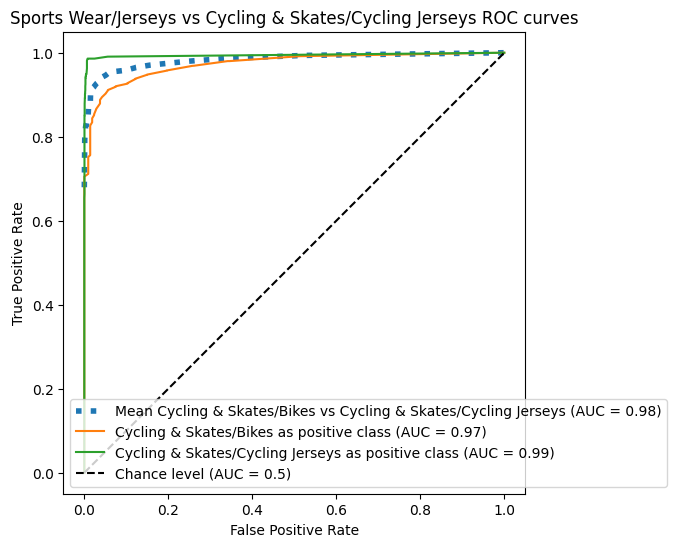

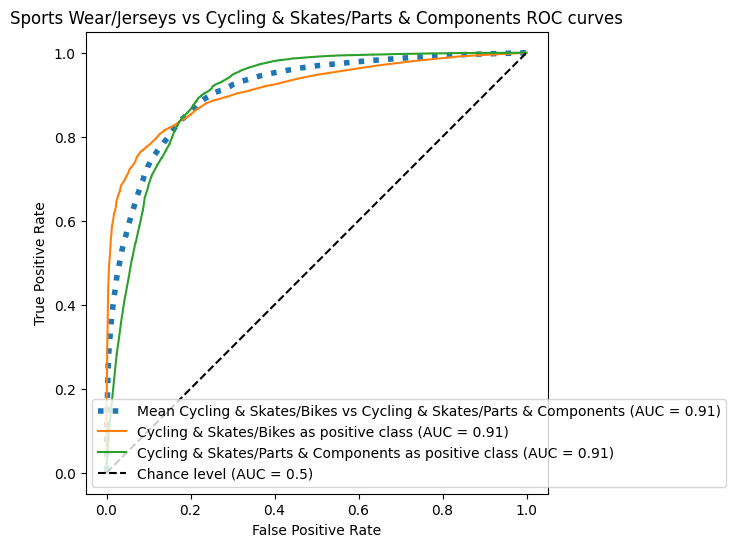

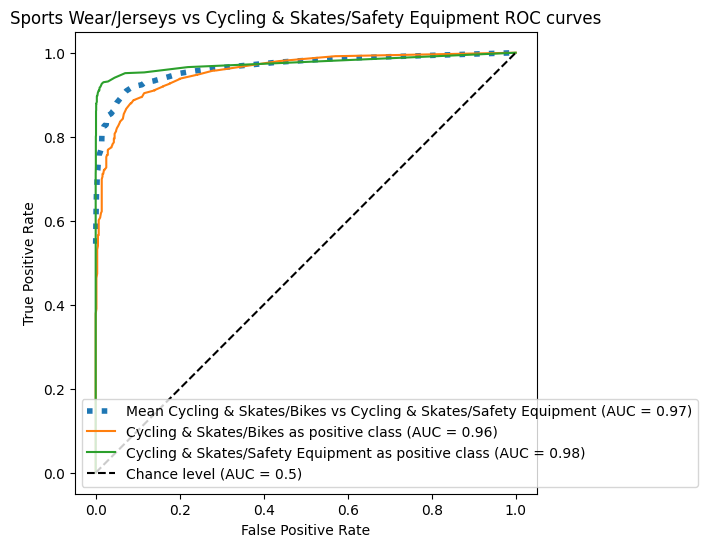

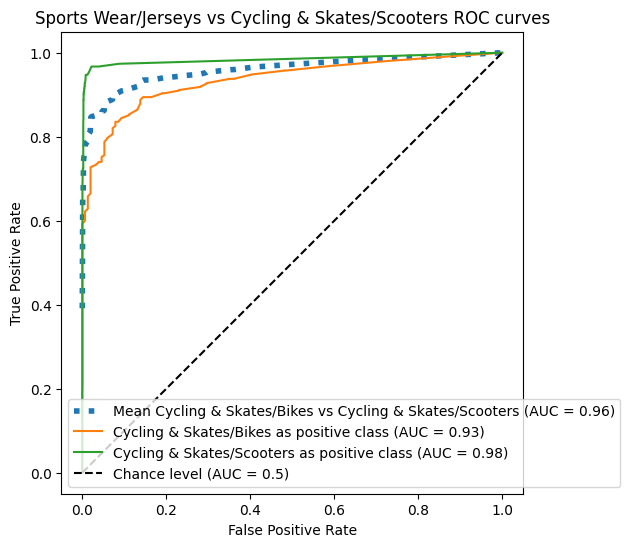

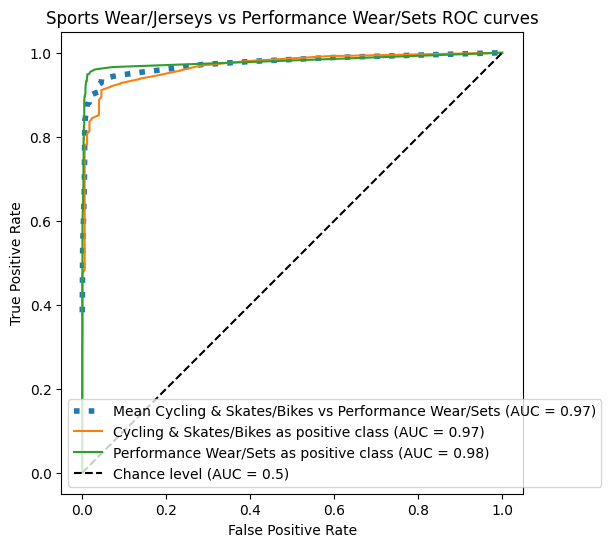

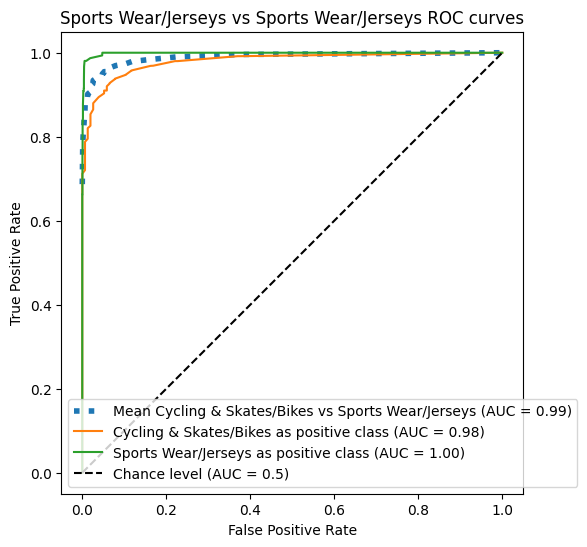

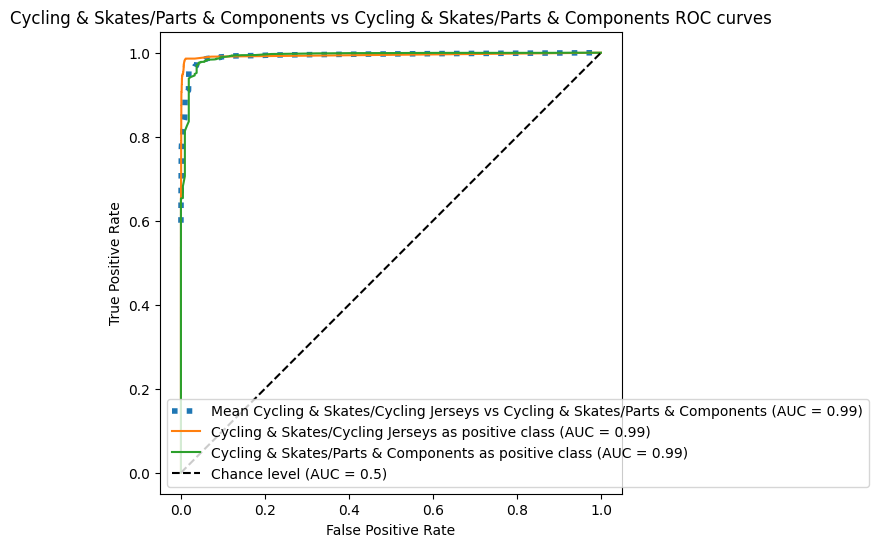

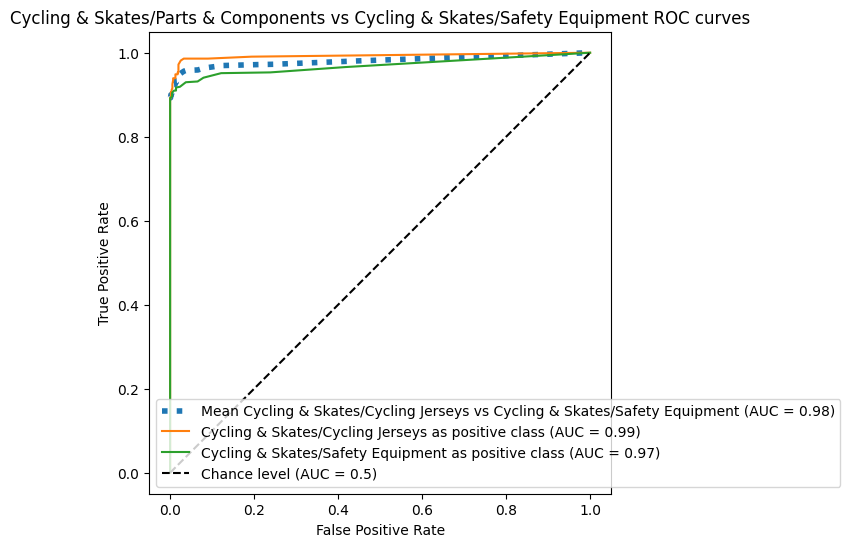

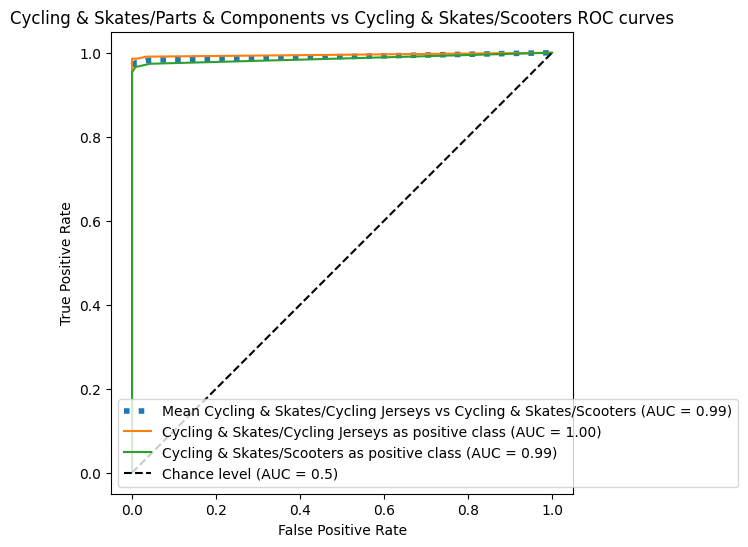

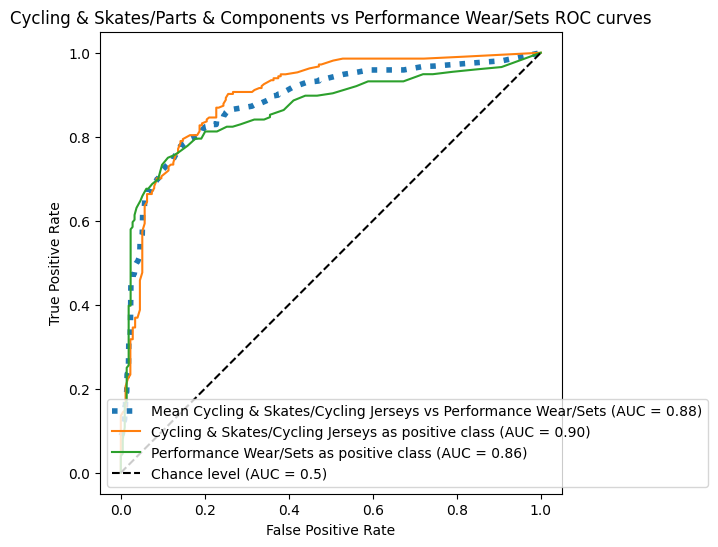

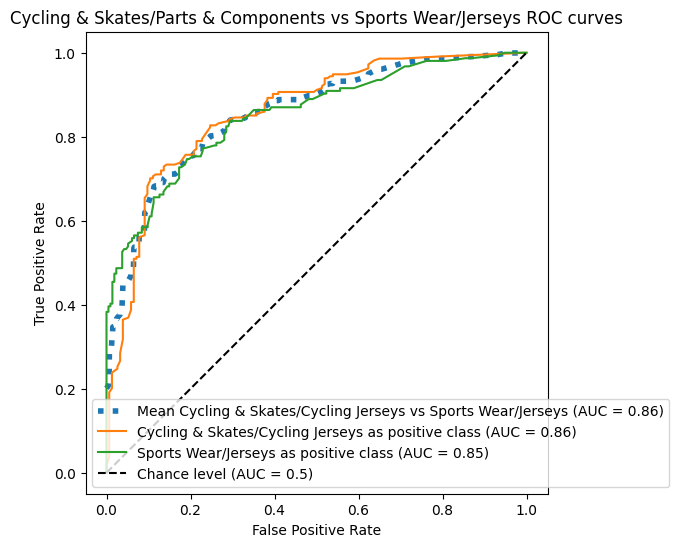

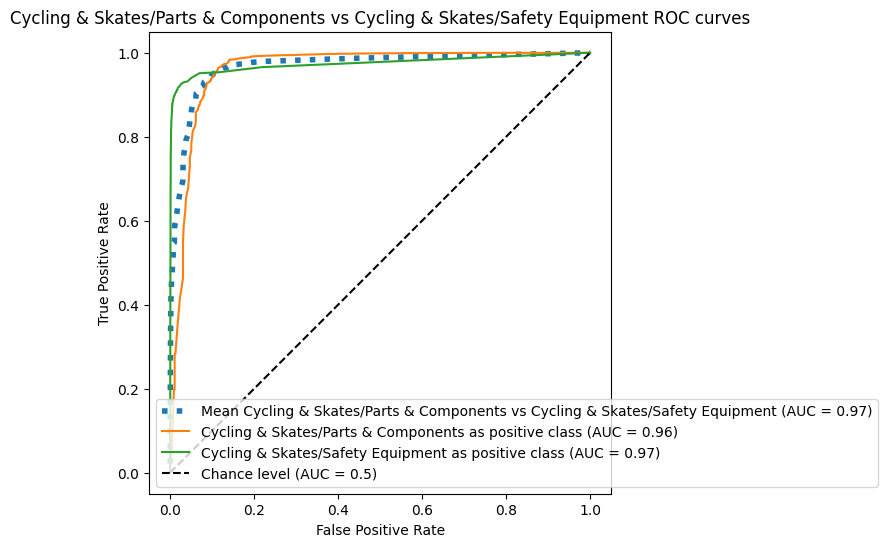

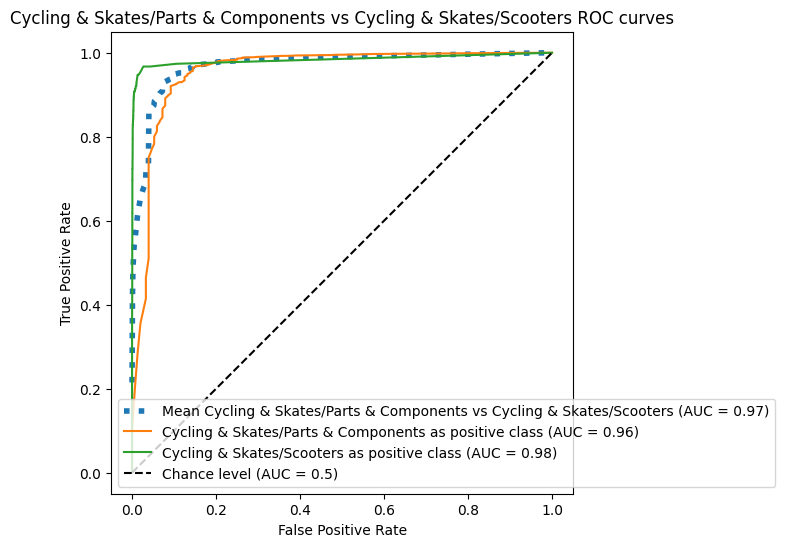

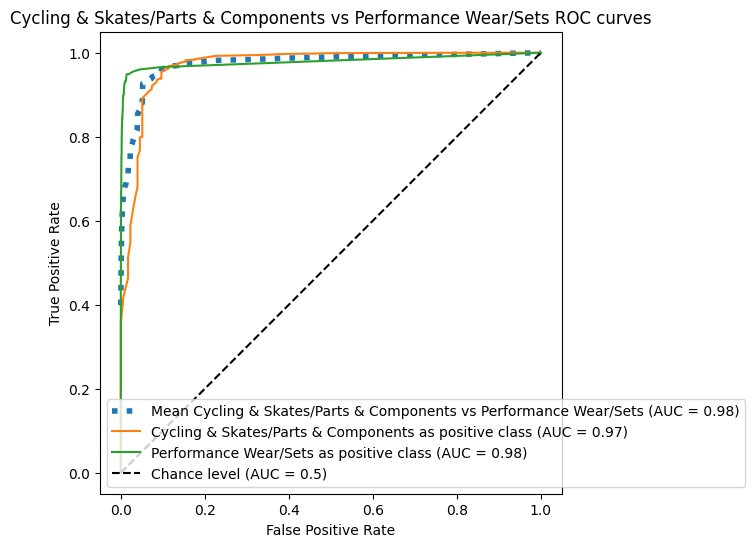

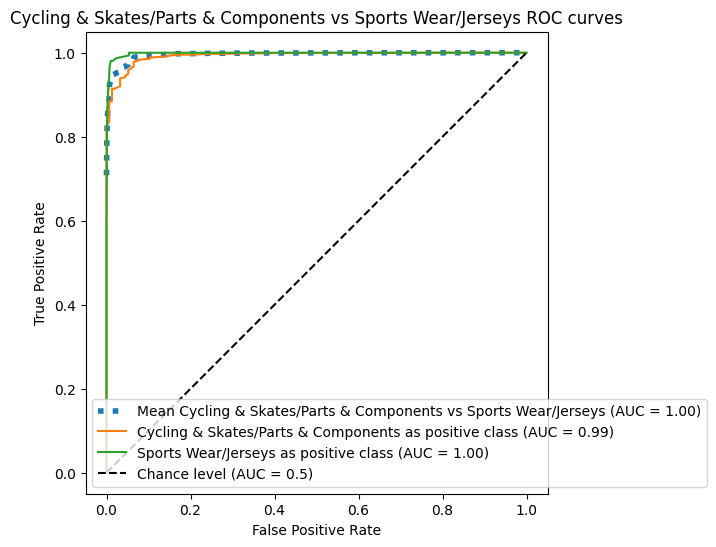

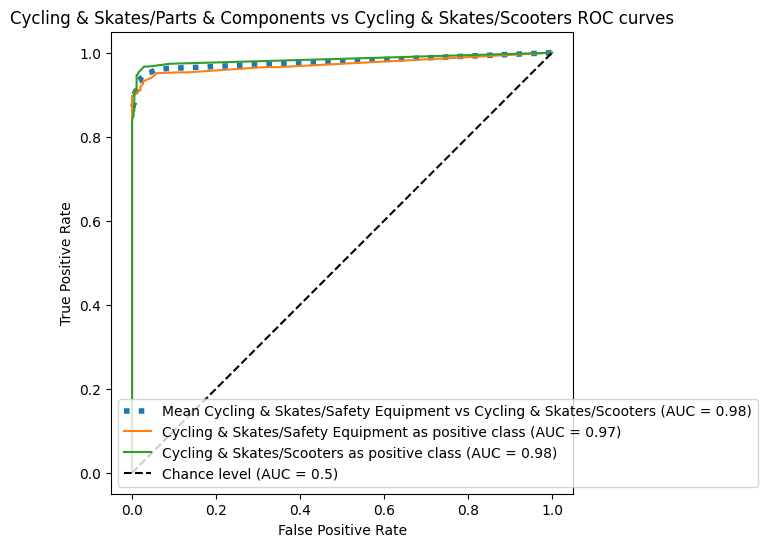

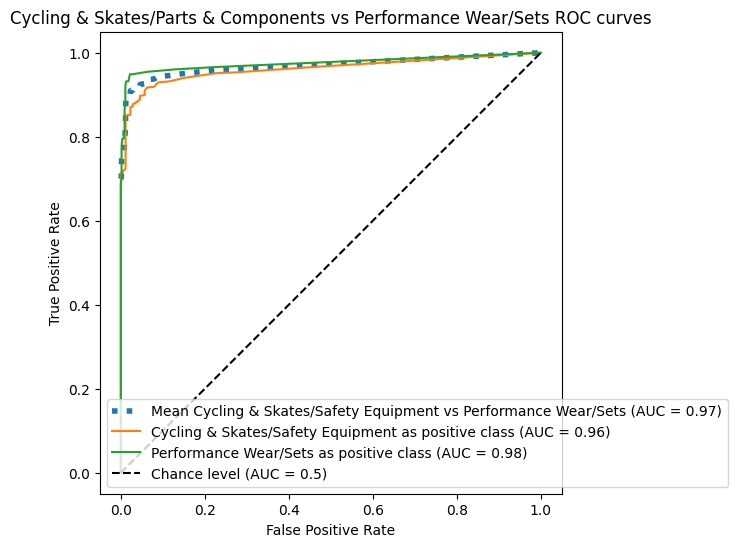

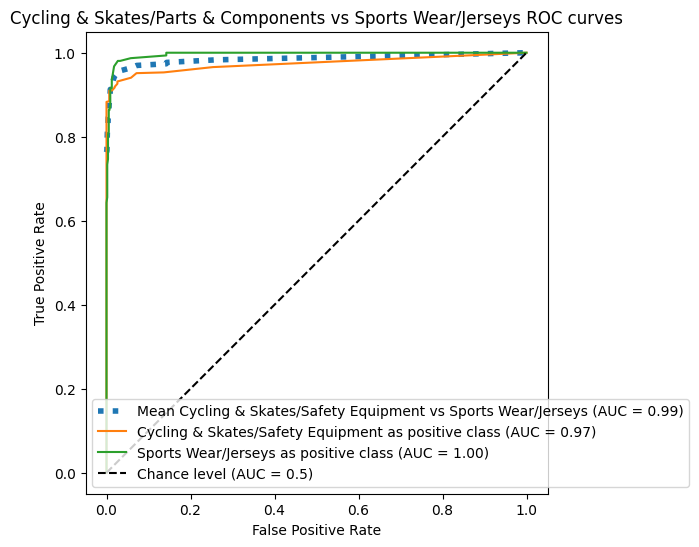

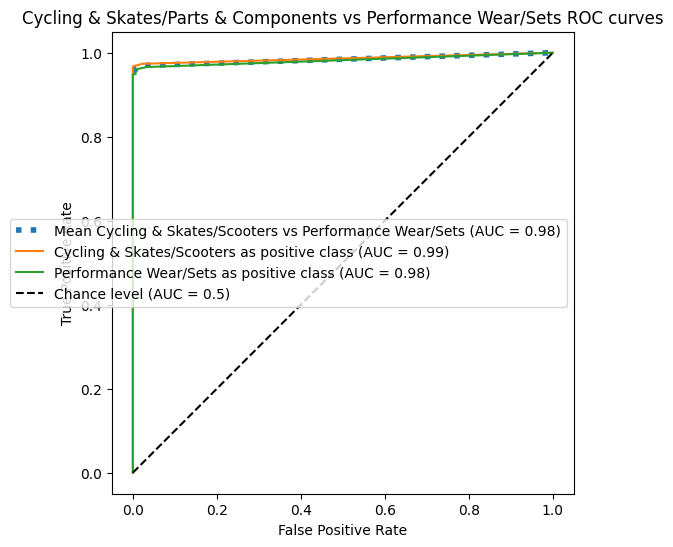

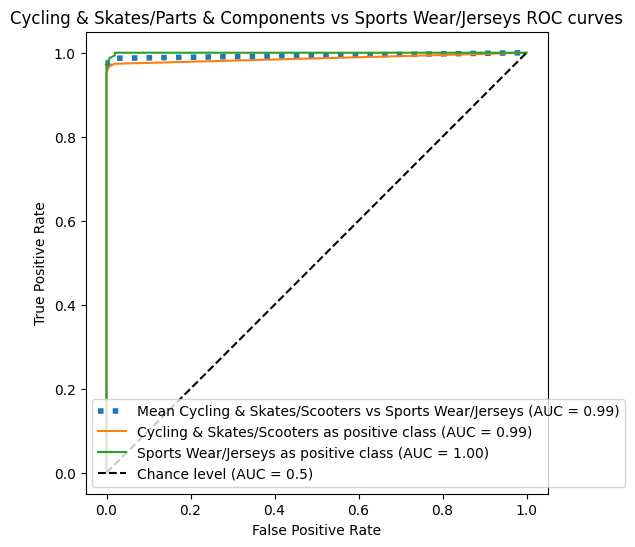

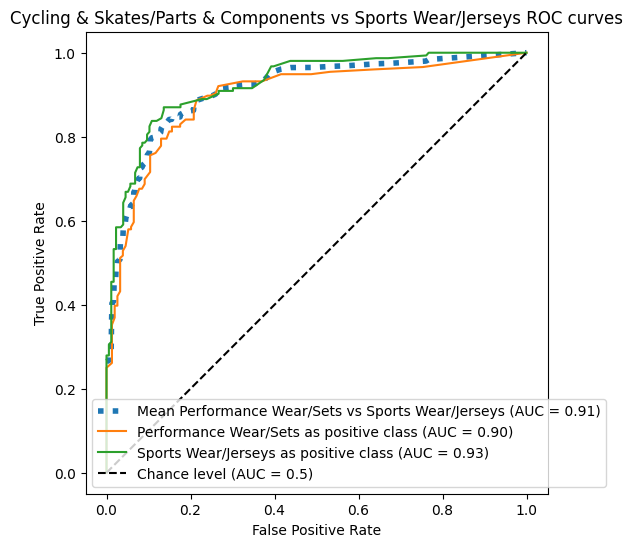

Macro-averaged One-vs-One ROC AUC score:
0.96


In [791]:
from sklearn.metrics import auc, roc_curve

pair_scores = []
mean_tpr = dict()

fpr_grid = np.linspace(0.0, 1.0, 1000)

for ix, (label_a, label_b) in enumerate(pair_list):
    a_mask = y_test_encoded == label_a
    b_mask = y_test_encoded == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_encoder.inverse_transform([label_a])[0]} vs {label_encoder.inverse_transform([label_b])[0]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_encoder.inverse_transform([label_a])[0]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_encoder.inverse_transform([label_b])[0]} as positive class",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{target_names[idx_a]} vs {label_encoder.inverse_transform([label_b])[0]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

In [836]:
weighted_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="weighted",
)

print(f"Weighted-averaged One-vs-One ROC AUC score:\n{macro_roc_auc_ovo:.2f}")

Weighted-averaged One-vs-One ROC AUC score:
0.97


#### Plot all OvO ROC curves together



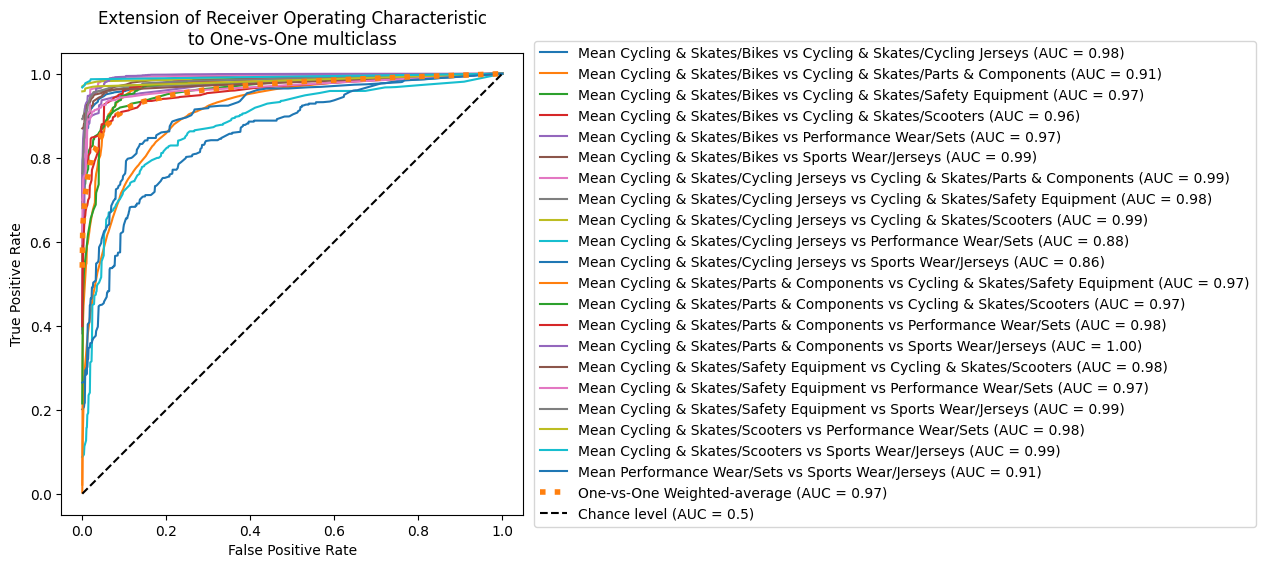

In [837]:
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(16, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_encoder.inverse_transform([label_a])[0]} vs {label_encoder.inverse_transform([label_b])[0]} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One Weighted-average (AUC = {weighted_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend(bbox_to_anchor=(2.6, 0.5), loc='right')
plt.show()

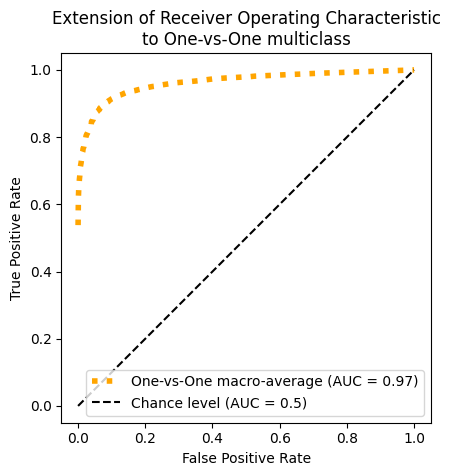

In [835]:
plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {weighted_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
    color = 'orange'
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()

### Coefficient analysis of features of each class

In [923]:
## I tried to do it with the random forest model, but I couldn't figure it out. So did what on Logreg which was the only way I knew how.

feature_names = tf_idf.get_feature_names_out()


for class_name, class_weight in pd.DataFrame(y_encoded).value_counts().head(20).items():

    class_index = list(logit_no_others_reduced.classes_).index(class_name)
    

    print(f"Top features for class {label_encoder.inverse_transform(class_name)[0]} (Weight: {class_weight}):")
    sorted_feature_indices = logit_no_others_reduced.coef_[class_index].argsort()[::-1]
    top_n_features = 7  
    for feature_index in sorted_feature_indices[:top_n_features]:
        print(f"{feature_names[feature_index]}: {'{:.4f}'.format(logit_no_others_reduced.coef_[class_index][feature_index])}")
    print("\n")

Top features for class Cycling & Skates/Parts & Components (Weight: 33908):
bicycle: 3.8438
fender: 3.5730
handlebar: 3.1309
saddle: 3.0796
chain: 2.8801
brake: 2.7803
seat: 2.6406


Top features for class Cycling & Skates/Bikes (Weight: 7603):
bike: 4.1272
speed: 2.9157
20: 2.8534
shimano: 2.6000
bicycle: 2.5065
gomax: 2.3541
camp: 2.3046


Top features for class Cycling & Skates/Safety Equipment (Weight: 1606):
helmet: 10.3053
helmets: 4.4488
knee: 2.4509
mips: 2.4477
abus: 2.3603
park: 2.3076
frontier: 2.2981


Top features for class Cycling & Skates/Cycling Jerseys (Weight: 675):
jersey: 7.8840
cycling: 3.5513
cyclepro: 1.7784
shirts: 1.6969
clothing: 1.6627
downhill: 1.6165
ykywbike: 1.5804


Top features for class Performance Wear/Sets (Weight: 520):
set: 5.0157
cycling: 4.8379
shorts: 3.3054
pant: 2.6025
rb: 2.5680
jersey: 2.3011
team: 1.9741


Top features for class Sports Wear/Jerseys (Weight: 486):
jersey: 6.2938
kl: 2.5847
ship: 2.5602
from: 2.4744
fishing: 2.2654
genuine: 2

### Testing on new data

In [925]:
newdf1 = pd.read_csv('new_data/products1.csv', index_col = 0, dtype = str)
newdf2 = pd.read_csv('new_data/products2.csv', index_col = 0, dtype = str)
newdf3 = pd.read_csv('new_data/products3.csv', index_col = 0, dtype = str)

newdf = pd.concat([newdf1, newdf2, newdf3], axis=0)

In [465]:
newdf.shape

(76142, 87)

In [926]:
#categorizing columns
int_cols = ['itemid', 'shopid',
            'stock',
            'ctime',
            'sold', 'historical_sold',
            'liked_count',
            'catid',
            'cmt_count',
            'flag',
            'cb_option',
            'price_min', 'price', 'price_max',
            'price_min_before_discount', 'price_before_discount', 'price_max_before_discount',
            'raw_discount',
            'item_rating.rcount_with_context', 'item_rating.rcount_with_image'] #ints
flt_cols = ['shop_rating', 'item_rating.rating_star'] #floats
bool_cols = ['has_lowest_price_guarantee', 'shopee_verified', 'show_shopee_verified_label',
             'is_cc_installment_payment_eligible', 'is_non_cc_installment_payment_eligible',
             'show_free_shipping', 'is_preferred_plus_seller', 'can_use_cod'] #bools
objects_cols = ['name', 'brand', 'shop_name', 'item_rating.rating_count'] #keep as is
category_cols = ['shop_location']
remove_cols = ['label_ids', 'image', 'images', 'currency', 'status', 'liked',
               'has_lowest_price_guarantee', 'show_discount', 'discount', 'tier_variations',
               'item_type', 'is_adult', 'badge_icon_type', 'is_official_shop',
               'show_official_shop_label', 'show_official_shop_label_in_title',
               'bundle_deal_id', 'can_use_bundle_deal', 'welcome_package_type',
               'can_use_wholesale', 'has_model_with_available_shopee_stock',
               'is_on_flash_sale', 'is_service_by_shopee', 'info',
               'data_type', 'flash_sale_ongoing_sold_count', 'flash_sale_stock',
               'is_mart'] #non_target cols

#Taking a subset of columns and rearranging for easier analysis
sub_cols = ['itemid',
            'shopid',
            'product_name',
            'brand',
            'price_min',
            'price',
            'price_max',
            'price_min_before_discount',
            'price_before_discount',
            'price_max_before_discount',
            'historical_sold',
            'sold',
            'catid',
            'stock',
            'raw_discount',
            'ctime',
            'liked_count',
            'cmt_count',
            'shop_name',
            'shop_location',
            'item_rating.rating_star',
            'item_rating.rating_count',
            'item_status',
            'show_shopee_verified_label',
            'show_free_shipping',
            'shopee_verified',
            'is_preferred_plus_seller',
            'is_cc_installment_payment_eligible',
            'cb_option',]

def get_formatted_df(df):

    #Removing any null products.
    df = df.drop_duplicates(subset=['itemid'], keep='first')
    df = df.dropna(subset=['itemid'])
    df = df.reset_index()
    df.shape

    #Dropping these as they have excessive null values.
    null_threshold = (85/100 * df.shape[0]) #Null values can't exceed 85% of len of df

    nullheavy_columns = df.isnull().sum().loc[df.isnull().sum().values > null_threshold].index

    df = df.drop(columns=nullheavy_columns)

    #Fillnas to allow further manipulations.
    df['discount'] = df['discount'].fillna('0') #str to maintain same dtype.

    df = df.dropna(subset=int_cols)
    df = df.dropna(subset=flt_cols)

    df = df.fillna('None')

    #Converting cols to appropriate dtypes and drop None for numerical columns
    df[int_cols] = df[int_cols].astype(int)
    df[flt_cols] = df[flt_cols].astype(float)
    df[category_cols] = df[category_cols].astype('category')
    for col in bool_cols:
        df[col] = df[col].map({'0': False, '1': True, 'False': False, 'True': True})


    #Convert ctime to datetime    
    df['ctime'] = pd.to_datetime(df['ctime'], unit='s')

    #Remove cols
    df = df.drop(columns=remove_cols)

    #Set the -1 values to base value for the prices before discount
    df['price_max_before_discount'] = df.apply(lambda row : row['price_max'] if (row['raw_discount'] == 0) else row['price_max_before_discount'], axis = 1)
    df['price_before_discount'] = df.apply(lambda row : row['price'] if (row['raw_discount'] == 0) else row['price_before_discount'], axis = 1)
    df['price_min_before_discount'] = df.apply(lambda row : row['price_min'] if (row['raw_discount'] == 0) else row['price_min_before_discount'], axis = 1)

    #Converting price into real life amounts
    price_cols = ['price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
                'price_max', 'price', 'price_min']

    df[price_cols] = df[price_cols].apply(lambda x : x/100000)

    df = df.rename(columns={'name':'product_name'})

    df = df[sub_cols]

    #set revenue columns
    df['revenue'] = df['price'] * df['sold']
    df['historical_revenue'] = df['price'] * df['historical_sold']

    #reset index
    df = df.reset_index(drop=True)

    return df

In [927]:
newdf = get_formatted_df(newdf)

In [928]:
newdf = newdf[newdf['catid'] == 100637]

In [929]:
newdf.shape

(59841, 31)

In [949]:
logit_test = LogisticRegression(random_state=14, max_iter=500, **logit_random_search.best_params_)

logit_test.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=500, random_state=14)

In [974]:
newdf_catpreds = rf_no_others_reduced.predict(tf_idf.transform(newdf['product_name']))

In [975]:
newdf['categories'] = newdf_catpreds

In [982]:
newdf['categories_decoded'] = newdf['categories'].apply(lambda x: label_encoder.inverse_transform([x])[0])

In [1024]:
newdf[['product_name', 'categories_decoded']].sample(10)

,product_name,categories_decoded
51792,YKYWBIKE Pro Cool Mesh Superlight Bike Cycling Base Layers Bicycle Short Sleeve Shirt Breathable Cycling Jerseys Cycling Clothin,Cycling & Skates/Cycling Jerseys
72185,Swivels Connectors Copper And Pvc Feeder Hook Small About 13mm/Large About 15mm,Cycling & Skates/Parts & Components
30176,[Speed Park] Fixed Line Tube For Frame C-Shaped Buckle Outer Fixing Set Price Is One C,Cycling & Skates/Parts & Components
46783,BSC Women Essentials TOUR Jersey 2.0 Sand,Sports Wear/Jerseys
31222,FKR 16X1.75/1.95 AV BICYCLE BUTYL TUBE,Cycling & Skates/Bikes
41462,3T Full Carbon Road Bike Handlebar Matte/Gloss Black Top Carbon Fiber Road Bicycle Handlebar 31.8mm*400/420/440mm,Cycling & Skates/Parts & Components
19253,BikeDIY [LOCAL] MTB Bike Hydraulic Brake Needle Compressing Bushing Brake Hose Bicycle Parts SLX XT XTR Deore 446 T01,Cycling & Skates/Parts & Components
17731,gofondo® Minpoc MAGNETIC clip-on small bag for your Brompton,Cycling & Skates/Bikes
26194,Time Road Pedal Xpro 10 (Black/Grey),Cycling & Skates/Parts & Components
34337,[MARIN] FAIRFAX 3 700C V URBAN BIKE (2022),Cycling & Skates/Bikes


In [1030]:
df.shape

(54041, 50)

In [1029]:
df.fe_categories.nunique()

54